# Vehicle Sequence Optimization for Efficient Paint Changeovers
### Using Genetic Algorithm, Simulated Annealing and Random Forrest Regression

In this notebook, the aim is to minimize the number of color changeovers required when processing vehicles in sequence on a production line. We will explore three optimization approaches.

### Loading and Preprocessing Data

Loading the vehicle data(vehicle's model, color, and batch number)

In [26]:
import pandas as pd

df = pd.read_csv('C:/Users/hp/Desktop/Sequence Optimization/seq_data.csv')

In [28]:
df.head()

,Vehicle_ID,Model,Color,Batch
0,1,Corolla,Silver,2
1,2,Cross,Silver,C5
2,3,Corolla,White,1
3,4,IMV,Black,A3
4,5,Yaris,Silver,5


In [3]:
def load_vehicle_data(data):
    """
    This function accepts a DataFrame with columns: 'Vehicle_ID', 'Model', 'Color', 'Batch'.
    and returns the processed data for color, model, and batch.
    """
    vehicle_data = data.copy()
    
    # Extract unique values for models, colors, and batches for easy reference
    models = vehicle_data['Model'].unique()
    colors = vehicle_data['Color'].unique()
    batches = vehicle_data['Batch'].unique()

    vehicle_data['Model_ID'] = vehicle_data['Model'].apply(lambda x: list(models).index(x))
    vehicle_data['Color_ID'] = vehicle_data['Color'].apply(lambda x: list(colors).index(x))
    vehicle_data['Batch_ID'] = vehicle_data['Batch'].apply(lambda x: list(batches).index(x))
    
    return vehicle_data, models, colors, batches

In [30]:
vehicle_data = load_vehicle_data(df)[0]
print(vehicle_data)

    Vehicle_ID    Model   Color Batch  Model_ID  Color_ID  Batch_ID
0            1  Corolla  Silver     2         0         0         0
1            2    Cross  Silver    C5         1         0         1
2            3  Corolla   White     1         0         1         2
3            4      IMV   Black    A3         2         2         3
4            5    Yaris  Silver     5         3         0         4
..         ...      ...     ...   ...       ...       ...       ...
95          96    Yaris  Silver     4         3         0         7
96          97  Corolla   White     1         0         1         2
97          98    Cross   White    C3         1         1        23
98          99    Yaris  Silver     4         3         0         7
99         100      IMV  Silver    A5         2         0        16

[100 rows x 7 columns]


### Define Constraints

To minimize the number of color changeovers and keep the batches and model types as continuous as possible. The following two functions calculate penalties for color changeovers and batch/model discontinuities:

In [36]:
def calculate_color_changes(sequence, vehicle_data):
    color_changes = 0
    for i in range(len(sequence) - 1):
        if vehicle_data.loc[sequence[i], 'Color_ID'] != vehicle_data.loc[sequence[i + 1], 'Color_ID']:
            color_changes += 1
    return color_changes

def calculate_batch_model_penalty(sequence, vehicle_data):
    batch_penalty = 0
    model_penalty = 0
    for i in range(len(sequence) - 1):
        # Check batch continuity
        if vehicle_data.loc[sequence[i], 'Batch_ID'] != vehicle_data.loc[sequence[i + 1], 'Batch_ID']:
            batch_penalty += 1
        # Check model continuity
        if vehicle_data.loc[sequence[i], 'Model_ID'] != vehicle_data.loc[sequence[i + 1], 'Model_ID']:
            model_penalty += 1
    return batch_penalty + model_penalty

### Implementing the Genetic Algorithm

We start with a random population of sequences and iteratively refine them. The algorithm selects, crosses, and mutates sequences based on a fitness function that combines color changeovers and continuity penalties.
Each generation, the algorithm selects the best sequences and applies crossover and mutation to create new sequences.

In [34]:
import random
import matplotlib.pyplot as plt

def fitness(sequence, vehicle_data, weight_color=1.0, weight_batch_model=0.5):
    color_changes = calculate_color_changes(sequence, vehicle_data)
    batch_model_penalty = calculate_batch_model_penalty(sequence, vehicle_data)
    # Total fitness with weights for color changes and batch/model penalties
    return weight_color * color_changes + weight_batch_model * batch_model_penalty

def genetic_algorithm(vehicle_data, num_generations=10000, population_size=20, mutation_rate=0.05):

    # Genetic algorithm to optimize vehicle sequence for minimal color changeovers and continuity.

    num_vehicles = len(vehicle_data)
    population = [random.sample(range(num_vehicles), num_vehicles) for _ in range(population_size)]
    best_fitness_progress = []
    
    for generation in range(num_generations):
        population = sorted(population, key=lambda seq: fitness(seq, vehicle_data))
        
        best_fitness = fitness(population[0], vehicle_data)
        best_fitness_progress.append(best_fitness)

        next_gen = population[:population_size // 2]
        
        while len(next_gen) < population_size:
            parent1, parent2 = random.sample(next_gen, 2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                child = mutate(child)
            next_gen.append(child)
        
        population = next_gen
    
   
    best_sequence = min(population, key=lambda seq: fitness(seq, vehicle_data))
    
    plt.plot(range(num_generations), best_fitness_progress, marker='o')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Score')
    plt.title('Genetic Algorithm Progress Over Generations')
    plt.grid(True)
    plt.show()
    
    return best_sequence

def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 2)
    child = parent1[:point] + [item for item in parent2 if item not in parent1[:point]]
    return child

def mutate(sequence):
    idx1, idx2 = random.sample(range(len(sequence)), 2)
    sequence[idx1], sequence[idx2] = sequence[idx2], sequence[idx1]
    return sequence

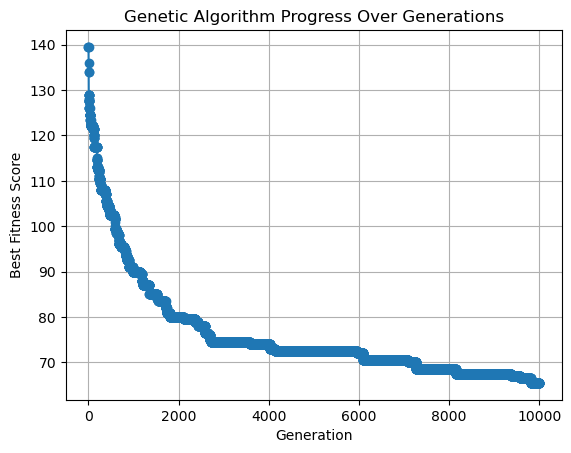

In [40]:
optseq_genetic = genetic_algorithm(vehicle_data)

In [51]:
actual_color_changes = calculate_color_changes(optseq_genetic, vehicle_data)

print("Color Changeovers:", actual_color_changes)

Color Changeovers: 26


### Implementing Simulated Annealing

Simulated Annealing is a probabilistic technique inspired by the annealing process in metallurgy.

In [41]:
import math

def simulated_annealing(vehicle_data, initial_temp=1000, cooling_rate=0.995, max_iter=1000):
    num_vehicles = len(vehicle_data)
    current_sequence = random.sample(range(num_vehicles), num_vehicles)
    current_fitness = fitness(current_sequence, vehicle_data)
    best_sequence = current_sequence
    best_fitness = current_fitness

    fitness_progress = []

    temp = initial_temp
    
    for iteration in range(max_iter):
        fitness_progress.append(best_fitness)
        
        neighbor_sequence = current_sequence[:]
        idx1, idx2 = random.sample(range(num_vehicles), 2)
        neighbor_sequence[idx1], neighbor_sequence[idx2] = neighbor_sequence[idx2], neighbor_sequence[idx1]
        
        neighbor_fitness = fitness(neighbor_sequence, vehicle_data)
        
        if neighbor_fitness < current_fitness:
            current_sequence = neighbor_sequence
            current_fitness = neighbor_fitness
        else:
            acceptance_prob = math.exp((current_fitness - neighbor_fitness) / temp)
            if acceptance_prob > random.random():
                current_sequence = neighbor_sequence
                current_fitness = neighbor_fitness

        if current_fitness < best_fitness:
            best_sequence = current_sequence
            best_fitness = current_fitness

        temp *= cooling_rate

    plt.plot(range(max_iter), fitness_progress, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness Score')
    plt.title('Simulated Annealing Progress Over Iterations')
    plt.grid(True)
    plt.show()
    
    return best_sequence, best_fitness

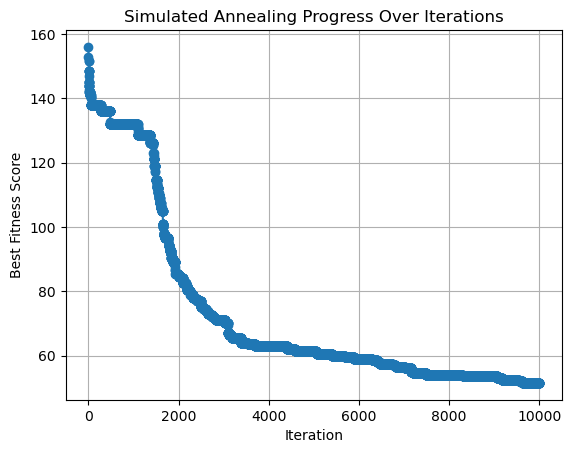

In [53]:
best_sequence, best_fitness = simulated_annealing(vehicle_data, initial_temp=1000, cooling_rate=0.995, max_iter=10000)

In [55]:
actual_color_changes = calculate_color_changes(optseq_genetic, vehicle_data)

print("Color Changeovers:", actual_color_changes)

Color Changeovers: 26


### Machine Learning, Random Forrest Regression model for Cost Prediction

Here we use machine learning to predict sequence costs. We generate training data by assessing random sequences with our fitness function, then train a Random Forest regression model to estimate costs.

In [57]:
import pandas as pd

def generate_training_data(vehicle_data, num_samples=500):
    num_vehicles = len(vehicle_data)
    training_data = []
    
    for _ in range(num_samples):
        sequence = random.sample(range(num_vehicles), num_vehicles)
        cost = fitness(sequence, vehicle_data)
        training_data.append((sequence, cost))
    
    training_df = pd.DataFrame(training_data, columns=['Sequence', 'Cost'])
    return training_df

In [59]:
training_df = generate_training_data(vehicle_data, num_samples=1000)

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def prepare_features_and_train(training_df, vehicle_data):
    features = []
    labels = training_df['Cost']
    
    for sequence in training_df['Sequence']:
        color_changes = calculate_color_changes(sequence, vehicle_data)
        batch_model_penalty = calculate_batch_model_penalty(sequence, vehicle_data)
        features.append([color_changes, batch_model_penalty])
  
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Model Mean Squared Error:", mse)
    
    return model

In [63]:
model = prepare_features_and_train(training_df, vehicle_data)

Model Mean Squared Error: 0.0851792500000001


In [65]:
def generate_candidate_sequences(vehicle_data, model, num_candidates=100):
    num_vehicles = len(vehicle_data)
    candidates = []
    
    for _ in range(num_candidates):
        sequence = random.sample(range(num_vehicles), num_vehicles)
        color_changes = calculate_color_changes(sequence, vehicle_data)
        batch_model_penalty = calculate_batch_model_penalty(sequence, vehicle_data)
        features = [[color_changes, batch_model_penalty]]
        predicted_cost = model.predict(features)[0]
        candidates.append((sequence, predicted_cost))
   
    candidates = sorted(candidates, key=lambda x: x[1])
    return candidates

In [67]:
candidates = generate_candidate_sequences(vehicle_data, model, num_candidates=100)

In [69]:
def optimize_sequence_with_ml(vehicle_data, model, num_candidates=100, top_k=10):
    best_sequence = None
    best_predicted_cost = float('inf')
    
    candidates = generate_candidate_sequences(vehicle_data, model, num_candidates=num_candidates)
    top_candidates = candidates[:top_k]
    for sequence, predicted_cost in top_candidates:
        if predicted_cost < best_predicted_cost:
            best_sequence = sequence
            best_predicted_cost = predicted_cost
    
    print("Best Predicted Cost:", best_predicted_cost)
    print("Optimized Sequence:", best_sequence)
    return best_sequence, best_predicted_cost


In [75]:
best_sequence, best_predicted_cost = optimize_sequence_with_ml(vehicle_data, model, num_candidates=10000, top_k=10)
actual_color_changes = calculate_color_changes(best_sequence, vehicle_data)

print("Color Changeovers:", actual_color_changes)

Best Predicted Cost: 130.235
Optimized Sequence: [9, 67, 77, 18, 50, 87, 94, 41, 17, 73, 55, 21, 3, 90, 10, 7, 40, 92, 37, 35, 60, 39, 4, 49, 75, 57, 69, 51, 24, 0, 25, 85, 36, 96, 66, 1, 33, 23, 93, 79, 43, 30, 14, 42, 61, 6, 12, 16, 29, 34, 45, 98, 22, 20, 32, 28, 76, 64, 48, 63, 27, 84, 46, 38, 13, 68, 8, 70, 53, 47, 11, 97, 15, 54, 89, 62, 52, 80, 88, 83, 81, 56, 26, 44, 78, 82, 65, 99, 95, 74, 72, 31, 19, 86, 58, 2, 5, 59, 91, 71]
Color Changeovers: 57


### Conclusion

In this notebook we investigated two optimization strategies and a machine learning technique to minimize color changeovers in vehicle sequencing:

- The **Genetic Algorithm** effectively achieved balanced solutions through iterative refinement.
- **Simulated Annealing** explored nearby solutions and produced reasonable results, though its convergence was heavily reliant on the cooling rate.
- The **Machine Learning (Random Forest)** approach predicted sequence costs, aiding in rapid identification of promising sequences, but was less adaptable in real-time compared to the Genetic Algorithm.

### Final Recommendation:
The **Genetic Algorithm** is recommended as the most effective approach for this challenge, with its population-based strategy and iterative improvement playing key roles in optimization.